# Map Matching Benchmarks

This notebook is intended as a supplement to the Sendai Map notebook. This notebook implements the competing map matching algorithms and tests them against the map-matching-dataset for comparison.

In [ ]:
import networkx as nx
import osmnx as ox 
import time
from shapely.geometry import Polygon
import os
import ujson as json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import dask

# Remove this when debugging
#import warnings
#warnings.filterwarnings('ignore')

import dask.bag as db

%matplotlib inline
#ox.__version__

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
# Data Input

df_track = db.read_text('Data/map-matching-dataset/*track.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_edges = db.read_text('Data/map-matching-dataset/*arcs.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_nodes = db.read_text('Data/map-matching-dataset/*nodes.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_gt = db.read_text('Data/map-matching-dataset/*route.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)

In our case, our data is already fused. But often you will have several datasets with asynchronous data that you will have to fuse first. We implemented a barebones method in mm_utils to handle this; you can see an example of how to use it in '02a Data Pre-Processing'.

Typically GPS/IMU data is recorded as Point geometries in a GDF.
However, some algorithms require a trajectory (LineStrings) despite this.
As a result, our framework requires both points (nodes) and trajectories (edges).
So we will need to create a "trajectory" by sequentially connecting our nodes

In [ ]:
# I wrote a utility function to do that, provided in mm_utils.

df_track_edges = df_track.map(mm_utils.point_to_traj)#, columns = {'timestamp':'first',
                                                     #  'altitude':'average',
                                                     #  'speed':'average',
                                                     #  'vertical accuracy':'last',
                                                     #  'horizontal accuracy':'last',
                                                     #  'oops':'notavalidmethod'})

There may be other data assigned to the nodes which we would like the edges to also reflect.
Some algorithms may use the auxiliary data from edges, which is why this is a concern.
There's no perfect way to do this assignment, but I included a few basic methods in mm_utils: 'first' node assignment, 'average' between nodes, and 'last' node assignment. That is the columns argument I used above.

In [ ]:
## Network data

# Unfortunately, BDD100K does not provide network data, so we will have to pull our own from OSM
# This is computationally intense, and since we have >50000 tracks, we can't do it all at once
# So instead we will define a function to do this, and create a Dask Bag by mapping it onto our dataset
# Then it will be lazily computed
# This does mean that running our algorithm will take significantly longer
# The obvious way to circumvent this is to download all the networks beforehand
# If you do this, you may wish to create an UBODT from the networks as well (a preprocessing step done by FMM)

#def bdd_to_network(df):
#    miny, minx, maxy, maxx = df.geometry.total_bounds
#    network = ox.graph_from_bbox(maxx+0.002, minx-0.002, maxy+0.002, miny-0.002, network_type="drive")
#    networknodes, networkedges = ox.graph_to_gdfs(network)
#    return [networknodes, networkedges]

#dfbag_network = dfbag.map(bdd_to_network)



Now we demonstrate how we can work with several algorithms at once in a modular fashion.

First we initialize the simulators, to be later applied.

In [ ]:
from algorithms import fmm_bin
from fmm import FastMapMatchConfig

### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005

fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None


### Algorithm Implementation here, if not in separate .py file


###

sim1 = fmm_bin.FMM(cfg = fmm_config)
#sim2 = EKF.Sim(cfg = cfg_file)


## If you have the ground truth, load it here
ground_truth = db.read_text('Data/map-matching-dataset/*route.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)


In [ ]:
## We will convert our Dask Bags to Dask Delayed objects so we can iterate over them. Then we will lazily call our function on our dataset
# Finally we will compute our results, and Dask will automatically parallelize our work.

gt = ground_truth.to_delayed()
te = df_track_edges.to_delayed()
tn = df_track.to_delayed()
ne = df_network_edges.to_delayed()
nn = df_network_nodes.to_delayed()

Now we are ready to run the simulator on a subsection (or all of) the data. Notice how easy it is to run algorithms in parallel-- all of the parallelization is handled by Dask Delayed, so even though our algorithm is only designed to handle one case at a time, it has already gained magnitudes of efficiency.

One small caveat-- even if your algorithm is technically 'independent', if you utilize python.os functions, you may run into I/O read/write errors. To circumvent this, use a dedicated library such as tempfile to systematically handle the temp file creation.

In [ ]:
## Let's see this!
sim1_results = []

n = 100

for i in range(n):
    sim1_results.append(dask.delayed(sim1.run)(te[i],
                                               tn[i],
                                               ne[i],
                                               nn[i],
                                               return_results=True))
    
#from dask.distributed import Client, LocalCluster


#cluster = LocalCluster()  # Launches a scheduler and workers locally
#client = Client(cluster)  # Connect to distributed cluster and override default
#client.restart()

In [ ]:

sim1_results[:3]

# Because FMM uses I/O operations, it is complicated to run it in parallel (as it will close files before the process finishes)
# You should write your algorithm to avoid I/O operations so you can avoid this altogether
sim1_results = dask.compute(*sim1_results, scheduler='sync')

#client.close()

#sim1.run(input_nodes = df_nodes, input_edges = df_edges, network_nodes = networknodes, network_edges = networkedges) # FMM doesn't consider input nodes or network nodes, so the inclusion here is superfluous
#sim1.results
#sim1_results

[Delayed('run-773a6364-fda3-4330-b408-520bd00bbac7'),
 Delayed('run-75dca5c6-203e-4048-baf6-05f6d7e4bef3'),
 Delayed('run-b5925766-f051-43b4-bc2b-54154dbc4581')]

[2022-07-25 13:59:28.028] [info] [network.cpp:72] Read network from file /tmp/tmphne6l3hj.shp
[2022-07-25 13:59:28.029] [warning] [network.cpp:124] SRID is not found, set to 4326 by default
[2022-07-25 13:59:28.045] [info] [network.cpp:170] Number of edges 18196 nodes 8542
[2022-07-25 13:59:28.045] [info] [network.cpp:171] Field index: id 0 source 1 target 2
[2022-07-25 13:59:28.054] [info] [network.cpp:174] Read network done.
[2022-07-25 13:59:28.659] [info] [network_graph.cpp:17] Construct graph from network edges start
[2022-07-25 13:59:28.660] [info] [network_graph.cpp:30] Graph nodes 8542 edges 18196
[2022-07-25 13:59:28.660] [info] [network_graph.cpp:31] Construct graph from network edges end
[2022-07-25 13:59:28.660] [info] [ubodt_gen_algorithm.cpp:76] Start to generate UBODT with delta 0.02
[2022-07-25 13:59:28.660] [info] [ubodt_gen_algorithm.cpp:77] Output format csv
[2022-07-25 13:59:28.809] [info] [ubodt_gen_algorithm.cpp:105] Progress 854 / 8542
[2022-07-25 13:59:28.923] [

Now we iterate through our results, and evaluate it using the build-in evaluation method in mm_utils.

In [ ]:
errors = []
for i in range(len(sim1_results)):
    errors.append(mm_utils.evaluate(sim1_results[i],
                                    gt[i].compute()[0],
                                    matchid = "index")) # A more standard match method would be 'geometry', but in this case index is more reliable

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb27bc0f490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb26034bdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb27bc0c7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb2603491e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb2603484c0>],
 'means': []}

Text(0.5, 1.0, 'FMM Error %s on 100 test cases \n(Average error = 0.1470121015322596)')

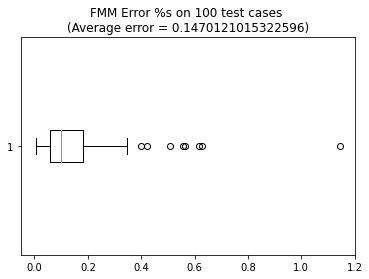

In [ ]:
fig = plt.figure(1)
plt.boxplot(errors,vert=False)
plt.title('FMM Error %s on ' 
          + str(n) 
          + ' test cases \n(Average error = ' 
          + str(np.average(errors)) + ')')
plt.show()

Overall, FMM seems to handle itself okay, with the exception of one huge outlier!

(Note-- having an error above 100% is not a bug; the standard error formula is not upper-bounded, despite being a percentage)

Let's see a few examples of our results.

Text(0.5, 0.98, 'FMM Evaluations Visualized')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, -0.5, 'Error: 0.06554302983591287')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, -0.5, 'Error: 0.03778692513848468')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, -0.5, 'Error: 0.19377037570255634')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, -0.5, 'Error: 0.18914820954188186')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, -0.5, 'Error: 0.13929787475976266')

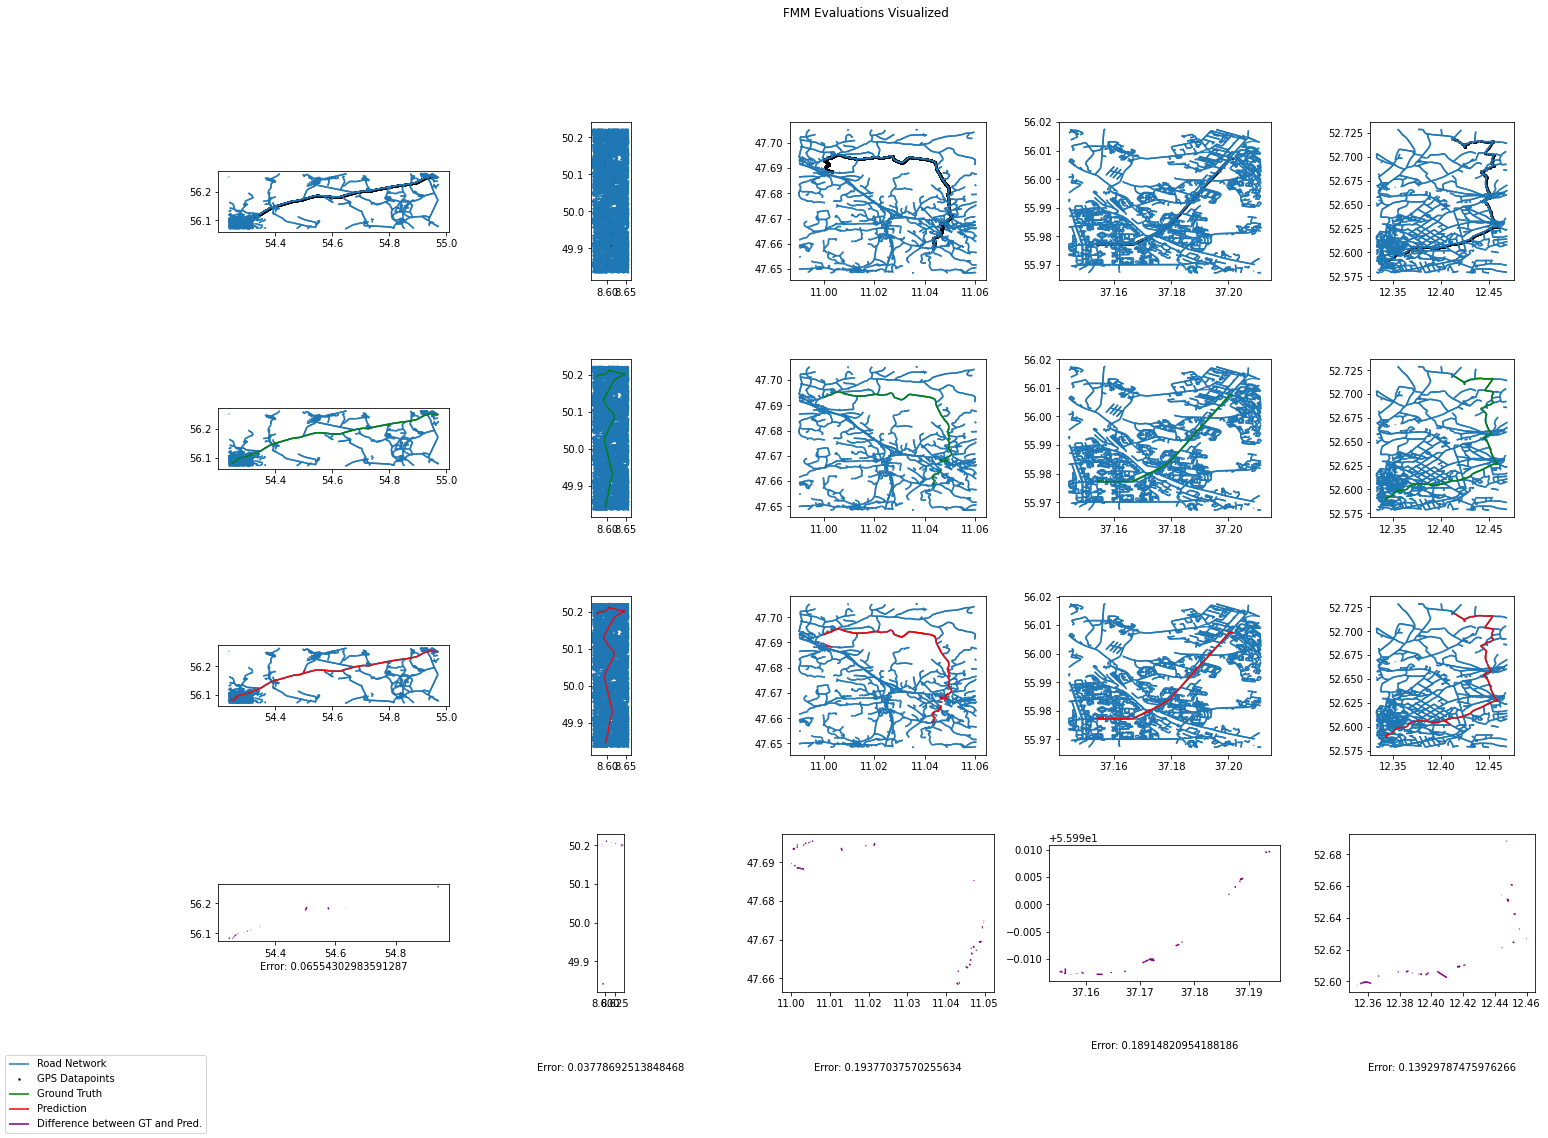

In [ ]:
n = 5
fig, axs = plt.subplots(4,n, figsize=(24,16))

fig.suptitle('FMM Evaluations Visualized')

for i in range(n):
    netemp = ne[i].compute()[0]
    gttemp = gt[i].compute()[0]
    netemp.plot(ax=axs[0,i])
    tn[i].compute()[0].plot(ax=axs[0,i], color='black',markersize=2)
    netemp.plot(ax=axs[1,i])
    gttemp.plot(ax=axs[1,i], color='green')
    netemp.plot(ax=axs[2,i])
    sim1_results[i].plot(ax=axs[2,i], color= 'red')
    evalint = gttemp.loc[np.intersect1d(gttemp['index'], sim1_results[i]['index'], return_indices=True)[1]]
    evalxor = pd.concat([gttemp.overlay(evalint, how="difference"), sim1_results[i].overlay(evalint, how = "difference")])
    evalxor.plot(ax=axs[3,i], color='purple')
    axs[3,i].text(0.5, -0.5, 'Error: ' + str(errors[i]), size=10, ha= 'center', transform=axs[3,i].transAxes)

fig.legend(handles=[axs[0,0].collections[0],axs[0,0].collections[1],axs[1,0].collections[1],axs[2,0].collections[1],axs[3,0].collections[0]], labels = ['Road Network', 'GPS Datapoints', 'Ground Truth', 'Prediction', 'Difference between GT and Pred.'], loc = 'lower left')
plt.savefig("Outputs/image.png",bbox_inches='tight',dpi=100) 
plt.subplots_adjust(hspace=0.5)